In [ ]:
!pip install datasets
!pip install transformers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
import string
import datasets
from datasets import load_dataset, Dataset
import torch

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


***Tải dữ liệu***


In [56]:
train_df = pd.read_parquet("https://huggingface.co/api/datasets/uit-nlp/vietnamese_students_feedback/parquet/default/train/0.parquet")
val_df = pd.read_parquet("https://huggingface.co/api/datasets/uit-nlp/vietnamese_students_feedback/parquet/default/validation/0.parquet")
test_df = pd.read_parquet("https://huggingface.co/api/datasets/uit-nlp/vietnamese_students_feedback/parquet/default/test/0.parquet")

In [57]:
combined_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
combined_df

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0
...,...,...,...
16170,"các slide khó hiểu , ngôn ngữ trong slide phức...",0,0
16171,giáo viên giảng dạy có tâm huyết .,2,0
16172,chia sẻ cho em nhiều điều hay .,2,0
16173,em tiếp thu chậm .,0,0


***Tổng quan tập dữ liệu***

In [58]:
train_df.describe()

,sentiment,topic
count,11426.000000,11426.000000
mean,1.027831,0.427184
std,0.979401,0.791747
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,2.000000,1.000000
max,2.000000,3.000000


In [59]:
val_df.describe()

,sentiment,topic
count,1583.000000,1583.000000
mean,1.063171,0.437145
std,0.974933,0.833669
min,0.000000,0.000000
25%,0.000000,0.000000
50%,2.000000,0.000000
75%,2.000000,1.000000
max,2.000000,3.000000


In [60]:
test_df.describe()


,sentiment,topic
count,3166.000000,3166.000000
mean,1.057170,0.422931
std,0.971742,0.798240
min,0.000000,0.000000
25%,0.000000,0.000000
50%,2.000000,0.000000
75%,2.000000,1.000000
max,2.000000,3.000000


In [61]:
train_df.head()

,sentence,sentiment,topic
0,slide giáo trình đầy đủ .,2,1
1,"nhiệt tình giảng dạy , gần gũi với sinh viên .",2,0
2,đi học đầy đủ full điểm chuyên cần .,0,1
3,chưa áp dụng công nghệ thông tin và các thiết ...,0,0
4,"thầy giảng bài hay , có nhiều bài tập ví dụ ng...",2,0


*Để có cái nhìn tổng quan về tập dữ liệu, chúng ta sẽ xem phân bố về cảm xúc của tâp dữ liệu*

In [62]:
train_df.groupby("sentiment").count()

,sentence,topic
sentiment,,
0,5325,5325
1,458,458
2,5643,5643


*Với 0 là cảm xúc tiêu cực, 1 là trung tính và 2 là tích cực ta thấy số lượng câu tích cực và tiêu cực gần như bằng nhau và số lượng câu trung tính là ít nhất với chỉ hơn 400 câu.*

In [63]:
print(train_df.iloc[0])
print(train_df.iloc[1000])
print(train_df.iloc[11000])

sentence     slide giáo trình đầy đủ .
sentiment                            2
topic                                1
Name: 0, dtype: object
sentence     giảng viên truyền đạt chưa hay .
sentiment                                   0
topic                                       0
Name: 1000, dtype: object
sentence     thầy dạy rất vui và rất nhiệt tình .
sentiment                                       2
topic                                           0
Name: 11000, dtype: object


In [64]:
train_df['sentence']


0                                slide giáo trình đầy đủ .
1           nhiệt tình giảng dạy , gần gũi với sinh viên .
2                     đi học đầy đủ full điểm chuyên cần .
3        chưa áp dụng công nghệ thông tin và các thiết ...
4        thầy giảng bài hay , có nhiều bài tập ví dụ ng...
                               ...                        
11421    chỉ vì môn game mà em học hai lần mà không qua...
11422                                 em cảm ơn cô nhiều .
11423                             giao bài tập quá nhiều .
11424                 giáo viên dạy dễ hiểu , nhiệt tình .
11425    gói gọn doubledot hay , tận tình , phù hợp với...
Name: sentence, Length: 11426, dtype: object

In [65]:
combined_df.isnull().sum()

sentence     0
sentiment    0
topic        0
dtype: int64

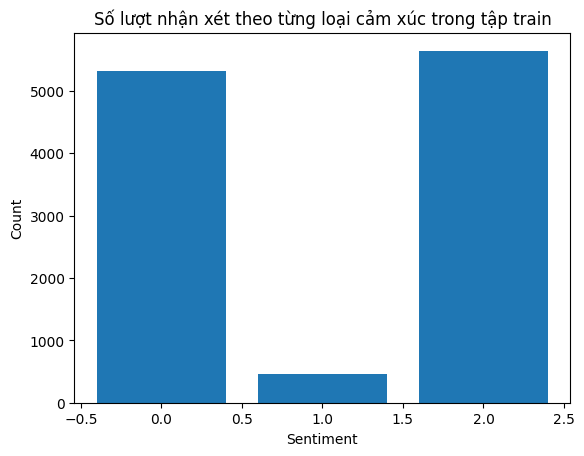

In [66]:
value_counts = train_df['sentiment'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.title('Số lượt nhận xét theo từng loại cảm xúc trong tập train')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

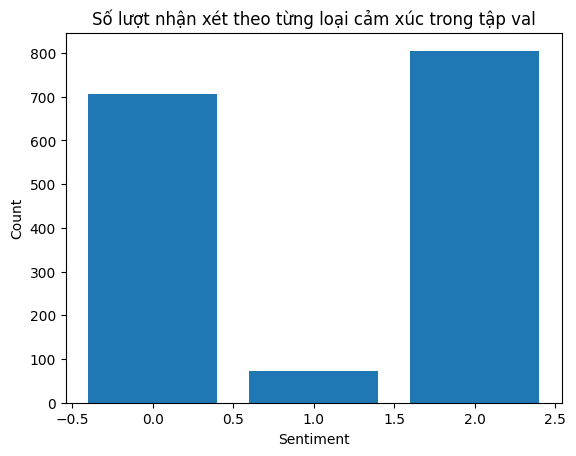

In [67]:
value_counts = val_df['sentiment'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.title('Số lượt nhận xét theo từng loại cảm xúc trong tập val')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

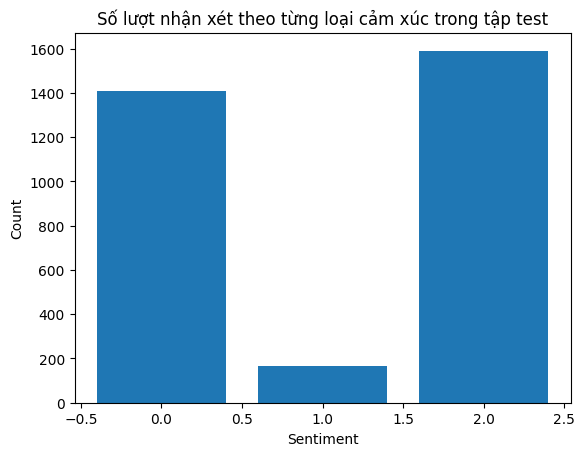

In [68]:
value_counts = test_df['sentiment'].value_counts()

plt.bar(value_counts.index, value_counts.values)
plt.title('Số lượt nhận xét theo từng loại cảm xúc trong tập test')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

In [69]:
def pretty_print_review_and_label(i):
    if train_df.sentiment[i]== 2:
        print("POSITIVE" + "\t" + train_df.sentence[i][:90] + "...")
    elif train_df.sentiment[i] == 1:
        print("NEU" + "\t " + train_df.sentence[i][:90] + "...")
    else:
        print("NEG" + "\t" + train_df.sentence[i][:90] + "...")
pretty_print_review_and_label(1)
pretty_print_review_and_label(70)
pretty_print_review_and_label(587)

POSITIVE	nhiệt tình giảng dạy , gần gũi với sinh viên ....
NEU	 ôn tập đúng theo thầy nhưng không biết cuối kỳ được mấy điểm ....
NEG	quá nhàm chán , không nâng cao được kiến thức ....
